In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.formula.api import ols

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
import seaborn as sns

In [5]:
from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

In [176]:
from shapely import wkt

In [66]:
demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d39 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_39.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
finance = pd.read_csv('../../council_campaign_finance/data/located_data_subset_for_member_chapters.csv')
ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)
nyc_zip = gpd.read_file('../data/Modified Zip Code Tabulation Areas (MODZCTA).geojson')
full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
full_results_thirty_nine = full_results[full_results['district'] == 39]
full_results_thirty_nine['dpp20bs'] = full_results_thirty_nine['dpp20bs'] / 10
mh_full = full_results[full_results['candidate'] ==  'Michael Hollingsworth'][['ed_name','vote_share']]
bw_full = full_results[full_results['candidate'] ==  'Brandon West'][['ed_name','vote_share']]
jk_full = full_results[full_results['candidate'] ==  'Jaslin Kaur'][['ed_name','vote_share']]
tc_full = full_results[full_results['candidate'] ==  'Tiffany Caban'][['ed_name','vote_share']]
aa_full = full_results[full_results['candidate'] ==  'Alexa Aviles'][['ed_name','vote_share']]

d39 = make_edname(d39)
d39_eds = d39['ed_name'].unique().tolist()


max_vote_share_candidates = pd.read_csv('../data/max_vote_share_candidates.csv')
tj = max_vote_share_candidates[['ed_name','candidate']]

occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip','w2cop']
wp_cols = [col for col in wp_cols if col not in to_remove]

C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\977684576.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_results_thirty_nine['dpp20bs'] = full_results_thirty_nine['dpp20bs'] / 10


In [68]:
mh_full.columns = ['ed_name','mh_vote']
bw_full.columns = ['ed_name','bw_vote']
jk_full.columns = ['ed_name','jk_vote']
tc_full.columns = ['ed_name','tc_vote']
aa_full.columns = ['ed_name','aa_vote']
council_dsa = mh_full.merge(bw_full, on='ed_name', how='outer')
council_dsa = council_dsa.merge(jk_full, on='ed_name', how='outer')
council_dsa = council_dsa.merge(tc_full, on='ed_name', how='outer')
council_dsa = council_dsa.merge(aa_full, on='ed_name', how='outer')

In [63]:
city_council = pd.concat([mh_full,bw_full,jk_full,tc_full,aa_full],axis=0)

In [9]:
colnames = ['a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j',
       'k', 
        'AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

good_cols = ['AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

In [10]:
fs = pd.read_csv('../data/fiftysixth_assembley.csv',header=None, names=colnames)
fs = fs[good_cols]

In [11]:
fs['precinct'] = 'AD: ' + fs['AD'].astype(str) + ' ' + 'ED: ' + fs['ED'].astype(str).str.zfill(3)
fs['ed_name'] = fs['AD'].astype(str) + fs['ED'].astype(str).str.zfill(3)

In [12]:
def import_clean(filepath,good_cols,colnames):
    df = pd.read_csv(filepath,header=None, names=colnames)
    df = df[good_cols]
    df['precinct'] = 'AD: ' + df['AD'].astype(str) + ' ' + 'ED: ' + df['ED'].astype(str).str.zfill(3)
    df['ed_name'] = df['AD'].astype(str) + df['ED'].astype(str).str.zfill(3)
    return df

In [13]:
candidates = ['Eon Huntley','Stefani L. Zinerman']

In [14]:
fs_cand = fs[fs['Unit Name'].isin(candidates)]
fs_cand = fs_cand[['precinct','ed_name','Unit Name','Tally']]
fs_cand = fs[fs['Unit Name'].isin(candidates)]
fs_cand = fs_cand[['precinct','ed_name','Unit Name','Tally']]
fs_cand.columns = ['precinct','ed_name','candidate','votes']
fs_cand['ed_total'] = fs_cand.groupby('ed_name')['votes'].transform('sum')
fs_cand['vote_share'] = round(fs_cand['votes'] / fs_cand['ed_total'] * 100,2)
fs_cand['vote_share'] = pd.to_numeric(fs_cand['vote_share'], errors='coerce')
max_vote_share_candidates = fs_cand.loc[fs_cand.groupby('ed_name')['vote_share'].idxmax()]
fs_cand['ed_total'] = fs_cand.groupby('ed_name')['votes'].transform('sum')
fs_cand['vote_share'] = round(fs_cand['votes'] / fs_cand['ed_total'] * 100,2)
fs_cand['vote_share'] = pd.to_numeric(fs_cand['vote_share'], errors='coerce')

In [15]:
def rearrange(df,candidates):
    df = df[df['Unit Name'].isin(candidates)]
    df = df[['precinct','ed_name','Unit Name','Tally']]
    df.columns = ['precinct','ed_name','candidate','votes']
    df['ed_total'] = df.groupby('ed_name')['votes'].transform('sum')
    df['vote_share'] = round(df['votes'] / df['ed_total'] * 100,2)
    df['vote_share'] = pd.to_numeric(df['vote_share'], errors='coerce')
    return df


In [16]:
df = import_clean('../data/fiftysixth_assembley.csv',good_cols,colnames)
df = rearrange(df,candidates)

In [17]:
salazar = import_clean('../data/salazar_raw_primary.csv',good_cols,colnames)
salazar['Unit Name'].value_counts()

Unit Name
Public Counter                244
Manually Counted Emergency    244
Absentee / Military           244
Affidavit                     244
Martin Malave Dilan           240
Julia Salazar                 240
Scattered                      75
Name: count, dtype: int64

In [101]:
gal = import_clean('../data/gal_primary.csv',good_cols,colnames)
gal['Unit Name'].value_counts()

Unit Name
Public Counter                107
Manually Counted Emergency    107
Absentee / Military           107
Federal                       107
Affidavit                     107
Emily E. Gallagher            102
Joseph R. Lentol              102
Scattered                      44
Name: count, dtype: int64

In [102]:
salazar_candidates = ['Martin Malave Dilan','Julia Salazar']
gal_candidates = ['Emily E. Gallagher','Joseph R. Lentol']

In [104]:
#salazar = rearrange(salazar,salazar_candidates)
gal = rearrange(gal,gal_candidates)

In [105]:
js = salazar[salazar['candidate'] == 'Julia Salazar']
eg = gal[gal['candidate'] == 'Emily E. Gallagher']

In [21]:
eh = df[df['candidate'] == 'Eon Huntley']
sz = df[df['candidate'] == 'Stefani L. Zinerman']

In [22]:
jb = pd.read_csv('../data/max_vote_share_candidates.csv')

In [23]:
fifty_seven = pd.read_csv('../data/fifty_seventh_assem.csv')
fifty_seven = fifty_seven[['aded','percphara','percmos']]
fifty_seven.columns = ['ed_name','phara_vote','mos']

In [24]:
eh['ed_name'] = eh['ed_name'].astype('Int64')

C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\3570298165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eh['ed_name'] = eh['ed_name'].astype('Int64')


In [25]:
eh_full_results = eh.merge(full_results, on='ed_name', how='left')

In [26]:
eh_full = eh_full_results[['vote_share_x','ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']]

In [27]:
eh_full.rename(columns={'vote_share_x':'vote_share'},inplace=True)

C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\22027880.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eh_full.rename(columns={'vote_share_x':'vote_share'},inplace=True)


In [28]:
cor_cols = ['ed_name','vote_share','garcia213p','white_transplant_ratio','dpp20bs','nhb21p','nha21p','mhhi21','cvap21bapp','ind21p','bang21p'] + wp_cols
corr_df = eh_full.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
corr_df = corr_df.merge(ae, left_on='ed_name', right_on='ElectDist', how='left')
corr_df['dpp20bs'] = corr_df['dpp20bs'] / 10
corr_matrix = corr_df[cor_cols].corr()
corr_matrix = corr_matrix.sort_values('vote_share')
vote_corr = corr_matrix[['vote_share']]

In [29]:
corr_df['log_mhhi21'] = np.log(corr_df['mhhi21'])

In [30]:
target = corr_df['vote_share']
mod1 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp']])).fit()
mod2 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','white_transplant_ratio']])).fit()
mod3 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','white_transplant_ratio','w2bgp','w2emrp','w2conp','w2mgtp']])).fit()
mod4 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','white_transplant_ratio','w2bgp','w2emrp','w2conp','w2mgtp','garcia213p','dpp20bs']])).fit()

In [31]:
jb.rename(columns={'vote_share':'jb_vote_share'},inplace=True)
jb = jb[['ed_name','jb_vote_share']]

In [112]:
js.rename(columns={'vote_share':'js_vote_share'},inplace=True)
js = js[['ed_name','js_vote_share']]

C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\300105212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  js.rename(columns={'vote_share':'js_vote_share'},inplace=True)


In [33]:
eh.rename(columns={'vote_share':'eh_vote_share'},inplace=True)
eh = eh[['ed_name','eh_vote_share']]

C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\1530602879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eh.rename(columns={'vote_share':'eh_vote_share'},inplace=True)


In [34]:
fifty_seven.rename(columns={'phara_vote':'ps_vote_share'},inplace=True)
ps = fifty_seven[['ed_name','ps_vote_share']]

In [106]:
eg.rename(columns={'vote_share':'eg_vote_share'},inplace=True)
eg = eg[['ed_name','eg_vote_share']]

C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\4272038687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eg.rename(columns={'vote_share':'eg_vote_share'},inplace=True)


In [35]:
ps.head()

,ed_name,ps_vote_share
0,57001,25.806452
1,57002,18.248175
2,57003,17.322835
3,57004,62.000000
4,57005,23.076923


In [113]:
dfs = [ps, jb, js, eh,eg]
for df in dfs:
    df['ed_name'] = df['ed_name'].astype('Int64')

C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\1810500948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ed_name'] = df['ed_name'].astype('Int64')


In [114]:

merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = merged_df.merge(df, on="ed_name", how="outer")

In [115]:
vote_cols = ['ps_vote_share', 'jb_vote_share', 'js_vote_share', 'eh_vote_share','eg_vote_share']

In [116]:
scalers = {}
for col in vote_cols:
    scaler = StandardScaler()
    valid = merged_df[[col]].dropna()
    scaler.fit(valid)
    scalers[col] = scaler
    merged_df[col + '_std'] = merged_df[col].apply(
        lambda x: scaler.transform([[x]])[0][0] if pd.notnull(x) else np.nan
    )

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScal

In [117]:
def compute_dsa_vote(row):
    orig_values = [row[col] for col in vote_cols if pd.notnull(row[col])]
    std_values = [row[col + '_std'] for col in vote_cols if pd.notnull(row[col])]
    
    if len(orig_values) == 0:
        return np.nan
    elif len(orig_values) == 1:
        return orig_values[0]
    else:
        mean_std = np.mean(std_values)
        composite = mean_std * scalers['ps_vote_share'].scale_[0] + scalers['ps_vote_share'].mean_[0]
        return composite


In [218]:
def compute_dsa_vote(row):
    std_values = [row[col + '_std'] for col in vote_cols if pd.notnull(row[col])]
    
    if not std_values:
        return np.nan
    return np.mean(std_values)

In [118]:
merged_df['dsa_vote'] = merged_df.apply(compute_dsa_vote, axis=1)

In [121]:
merged_df[['ed_name','ps_vote_share','jb_vote_share','js_vote_share','eh_vote_share','eg_vote_share','dsa_vote']].sample(10)

,ed_name,ps_vote_share,jb_vote_share,js_vote_share,eh_vote_share,eg_vote_share,dsa_vote
161,52050,NaN,64.44,NaN,NaN,NaN,64.440000
539,50026,NaN,NaN,NaN,NaN,65.64,65.640000
496,54084,NaN,NaN,70.75,NaN,NaN,70.750000
137,51054,NaN,55.24,NaN,NaN,NaN,55.240000
317,50046,NaN,NaN,77.97,NaN,71.00,67.890488
28,57029,48.525469,57.22,NaN,NaN,NaN,48.394867
439,54024,NaN,NaN,66.23,NaN,NaN,66.230000
552,50039,NaN,NaN,NaN,NaN,70.42,70.420000
52,57053,55.102041,56.91,NaN,NaN,NaN,51.409416
438,54023,NaN,NaN,53.21,NaN,NaN,53.210000


In [122]:
dsa_vote_df = merged_df[['ed_name','dsa_vote']]
dsa_vote_df.dropna(inplace=True)

C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\746338939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsa_vote_df.dropna(inplace=True)


In [123]:
winner = full_results[full_results['winner'] == True]

In [124]:
dsa_vote_full = dsa_vote_df.merge(winner[['ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']],on='ed_name', how='left')
city_council_full = city_council.merge(winner[['ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']],on='ed_name', how='left')

In [125]:
cor_cols = ['ed_name','dsa_vote','garcia213p','white_transplant_ratio','dpp20bs','nhb21p','nha21p','mhhi21','cvap21bapp','ind21p','bang21p'] + wp_cols
corr_df = dsa_vote_full.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
corr_df = corr_df.merge(ae, left_on='ed_name', right_on='ElectDist', how='left')
corr_df['dpp20bs'] = corr_df['dpp20bs'] / 10
corr_matrix = corr_df[cor_cols].corr()
corr_matrix = corr_matrix.sort_values('dsa_vote')
vote_corr = corr_matrix[['dsa_vote']]

In [126]:
cor_cols = ['ed_name','dsa_vote','garcia213p','white_transplant_ratio','dpp20bs','nhb21p','nha21p','mhhi21','cvap21bapp','ind21p','bang21p'] + wp_cols
cc_corr_df = city_council_full.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
cc_corr_df = cc_corr_df.merge(ae, left_on='ed_name', right_on='ElectDist', how='left')
cc_corr_df['dpp20bs'] = cc_corr_df['dpp20bs'] / 10
cc_corr_matrix = cc_corr_df[cor_cols].corr()
cc_corr_matrix = cc_corr_matrix.sort_values('dsa_vote')
cc_vote_corr = cc_corr_matrix[['dsa_vote']]

In [127]:
corr_df['log_mhhi21'] = np.log(corr_df['mhhi21'])
cc_corr_df['log_mhhi21'] = np.log(corr_df['mhhi21'])

In [128]:
corr_df.dropna(inplace=True)
cc_corr_df.dropna(inplace=True)

In [129]:
target = corr_df['dsa_vote']
demo_mod = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','white_transplant_ratio']])).fit()
occ_mod = sm.OLS(target,sm.add_constant(corr_df[['w2hsp','w2tranp','w2admp','w2mgtp','w2banp','w2cmp']])).fit()
combined_mod = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','white_transplant_ratio','w2hsp','w2tranp','w2admp','w2mgtp','w2banp','w2cmp']])).fit()
summary_col([demo_mod,occ_mod,combined_mod],stars=True)

,dsa_vote I,dsa_vote II,dsa_vote III
const,30.4795***,44.9729***,31.8983***
,(3.7268),(2.7736),(4.3898)
log_mhhi21,0.8673**,,0.9433**
,(0.3853),,(0.3860)
cvap21bapp,0.0165,,0.1068
,(0.0670),,(0.0747)
white_transplant_ratio,1.0841***,,0.9806***
,(0.1458),,(0.1543)
w2hsp,,-0.2568***,-0.0546
,,(0.0876),(0.0855)


C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\2614175188.py:54: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=coef_df, y="Variable", x="Coefficient", hue="Model",
C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\2614175188.py:54: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=coef_df, y="Variable", x="Coefficient", hue="Model",


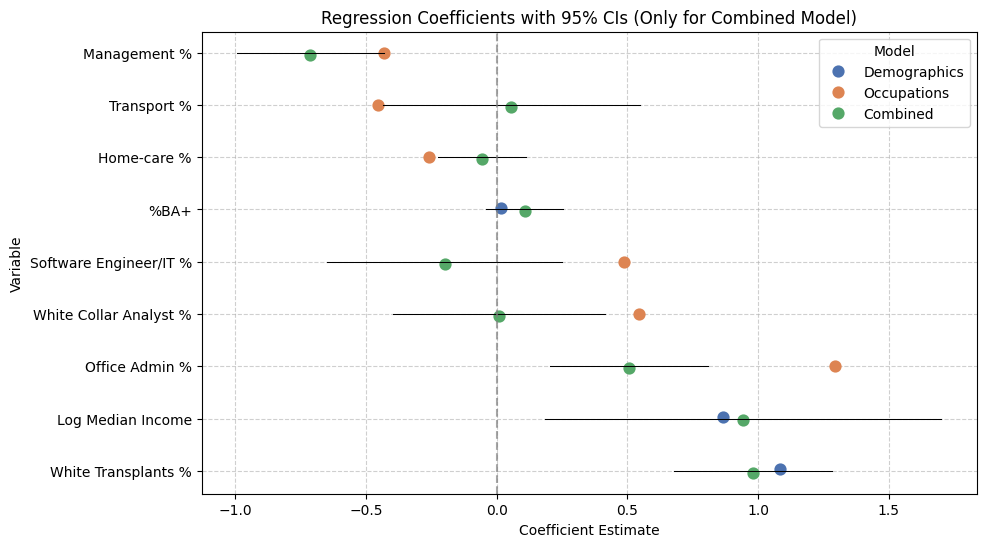

In [130]:
models = {
    "Demographics": demo_mod,
    "Occupations": occ_mod,
    "Combined": combined_mod
}

var_labels = {
    "log_mhhi21": "Log Median Income",
    "cvap21bapp": "%BA+",
    "white_transplant_ratio": "White Transplants %",
    "w2hsp": "Home-care %",
    "w2tranp": "Transport %",
    "w2admp": "Office Admin %",
    "w2mgtp": "Management %",
    "w2banp": "White Collar Analyst %",
    "w2cmp": "Software Engineer/IT %"
}

coef_df = []
ci_df = []  
for model_name, model in models.items():
    params = model.params
    conf = model.conf_int()
    conf.columns = ['Lower CI', 'Upper CI']
    
    for var in params.index:
        if var == 'const':
            continue  
        coef_df.append({
            "Variable": var_labels.get(var, var), 
            "Coefficient": params[var],
            "Model": model_name
        })
        
        if model_name == "Combined":
            ci_df.append({
                "Variable": var_labels.get(var, var),
                "Lower CI": conf.loc[var, 'Lower CI'],
                "Upper CI": conf.loc[var, 'Upper CI']
            })

coef_df = pd.DataFrame(coef_df)
ci_df = pd.DataFrame(ci_df)


coef_df["Variable"] = pd.Categorical(coef_df["Variable"], 
                                     categories=coef_df.groupby("Variable")["Coefficient"].mean().sort_values().index, 
                                     ordered=True)


plt.figure(figsize=(10, 6))


sns.pointplot(data=coef_df, y="Variable", x="Coefficient", hue="Model", 
              dodge=True, join=False, palette="deep", capsize=0.2,
              errwidth=1, markers="o")


for i, row in ci_df.iterrows():
    plt.plot([row["Lower CI"], row["Upper CI"]], 
             [row["Variable"], row["Variable"]], 
             color='black', linewidth=.75)


plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel("Coefficient Estimate")
plt.ylabel("Variable")
plt.title("Regression Coefficients with 95% CIs (Only for Combined Model)")
plt.legend(title="Model")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


C:\Users\samtg\AppData\Local\Temp\ipykernel_19960\3114207573.py:53: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=coef_df, y="Variable", x="Coefficient", hue="Model",
C:\Users\samtg\AppData\Local\Temp\ipykernel_19960\3114207573.py:53: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=coef_df, y="Variable", x="Coefficient", hue="Model",


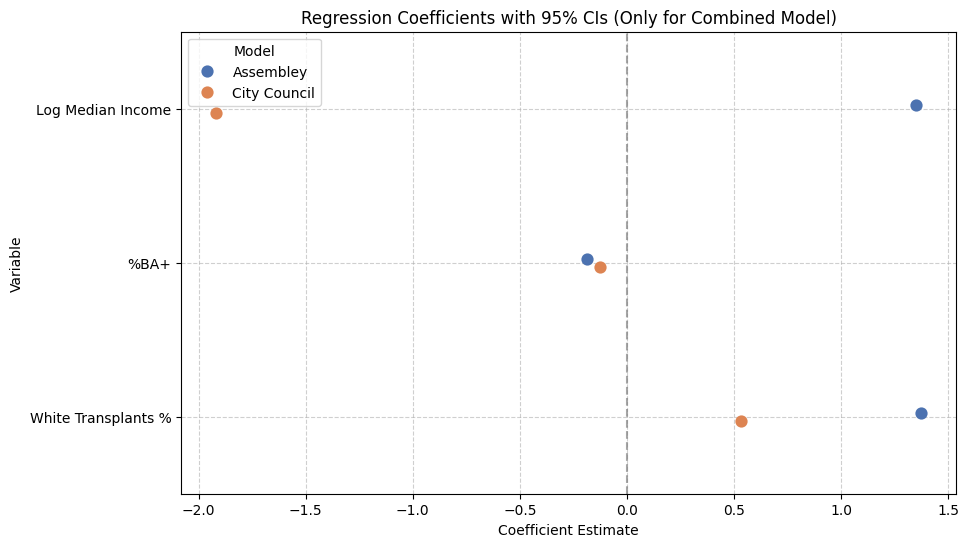

In [128]:
models = {
    "Assembley": demo_mod,
    "City Council": cc_demo_mod
}

var_labels = {
    "log_mhhi21": "Log Median Income",
    "cvap21bapp": "%BA+",
    "white_transplant_ratio": "White Transplants %",
    "w2hsp": "Home-care %",
    "w2tranp": "Transport %",
    "w2admp": "Office Admin %",
    "w2mgtp": "Management %",
    "w2banp": "White Collar Analyst %",
    "w2cmp": "Software Engineer/IT %"
}

coef_df = []
ci_df = []  
for model_name, model in models.items():
    params = model.params
    conf = model.conf_int()
    conf.columns = ['Lower CI', 'Upper CI']
    
    for var in params.index:
        if var == 'const':
            continue  
        coef_df.append({
            "Variable": var_labels.get(var, var), 
            "Coefficient": params[var],
            "Model": model_name
        })
        
        if model_name == "Combined":
            ci_df.append({
                "Variable": var_labels.get(var, var),
                "Lower CI": conf.loc[var, 'Lower CI'],
                "Upper CI": conf.loc[var, 'Upper CI']
            })

coef_df = pd.DataFrame(coef_df)
ci_df = pd.DataFrame(ci_df)


coef_df["Variable"] = pd.Categorical(coef_df["Variable"], 
                                     categories=coef_df.groupby("Variable")["Coefficient"].mean().sort_values().index, 
                                     ordered=True)


plt.figure(figsize=(10, 6))


sns.pointplot(data=coef_df, y="Variable", x="Coefficient", hue="Model", 
              dodge=True, join=False, palette="deep", capsize=0.2,
              errwidth=1, markers="o")


for i, row in ci_df.iterrows():
    plt.plot([row["Lower CI"], row["Upper CI"]], 
             [row["Variable"], row["Variable"]], 
             color='black', linewidth=.75)


plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel("Coefficient Estimate")
plt.ylabel("Variable")
plt.title("Regression Coefficients with 95% CIs (Only for Combined Model)")
plt.legend(title="Model")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [129]:
mc = pd.read_csv('../data/meta_cluster_MARCH17.csv')

In [132]:
prog_clust = mc[mc['new_cluster'] == 4]
prog_clust = prog_clust[['proper_name','new_cluster']]

In [ ]:
from unidecode import unidecode

In [138]:
from unidecode import unidecode

In [146]:
prog_clust['candidate'] = prog_clust['proper_name'].apply(unidecode)

In [160]:
prog_full = prog_clust[['candidate','new_cluster']].merge(full_results[['ed_name','vote_share','candidate','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']],on='candidate', how='left')
prog_full = prog_full.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')

In [161]:
dsa = ['Alexa Aviles','Brandon West','Jaslin Kaur','Michael Hollingsworth','Tiffany Caban']
dsa_full = prog_full[prog_full['candidate'].isin(dsa)]
non_dsa_full = prog_full[~prog_full['candidate'].isin(dsa)]

In [162]:
dsa_full['log_mhhi21'] = np.log(dsa_full['mhhi21'])
non_dsa_full['log_mhhi21'] = np.log(non_dsa_full['mhhi21'])

C:\Users\samtg\AppData\Local\Temp\ipykernel_19960\1251851643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsa_full['log_mhhi21'] = np.log(dsa_full['mhhi21'])
C:\Users\samtg\AppData\Local\Temp\ipykernel_19960\1251851643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_dsa_full['log_mhhi21'] = np.log(non_dsa_full['mhhi21'])


In [163]:
target = dsa_full['vote_share']
dsa_demo_mod = sm.OLS(target,sm.add_constant(dsa_full[['log_mhhi21','cvap21bapp','white_transplant_ratio']])).fit()
dsa_occ_mod = sm.OLS(target,sm.add_constant(dsa_full[['w2hsp','w2tranp','w2admp','w2mgtp','w2banp','w2cmp']])).fit()
dsa_combined_mod = sm.OLS(target,sm.add_constant(dsa_full[['log_mhhi21','cvap21bapp','white_transplant_ratio','w2hsp','w2tranp','w2admp','w2mgtp','w2banp','w2cmp']])).fit()
cc_target = non_dsa_full['vote_share']
demo_mod = sm.OLS(cc_target,sm.add_constant(non_dsa_full[['log_mhhi21','cvap21bapp','white_transplant_ratio']])).fit()
occ_mod = sm.OLS(cc_target,sm.add_constant(non_dsa_full[['w2hsp','w2tranp','w2admp','w2mgtp','w2banp','w2cmp']])).fit()
combined_mod = sm.OLS(cc_target,sm.add_constant(non_dsa_full[['log_mhhi21','cvap21bapp','white_transplant_ratio','w2hsp','w2tranp','w2admp','w2mgtp','w2banp','w2cmp']])).fit()
summary_col([dsa_demo_mod,dsa_occ_mod,dsa_combined_mod,demo_mod,occ_mod,combined_mod],stars=True)

,vote_share I,vote_share II,vote_share III,vote_share IIII,vote_share IIIII,vote_share IIIIII
const,7.5610,36.9671***,17.0226,63.1743***,41.5149***,73.4471***
,(13.6126),(3.8155),(13.3205),(3.9488),(3.0857),(4.8787)
log_mhhi21,1.6637,,1.8524,-1.5232***,,-1.8400***
,(1.3895),,(1.3260),(0.4115),,(0.4116)
cvap21bapp,0.1936*,,0.0310,-0.6950***,,-0.9648***
,(0.1118),,(0.1239),(0.0661),,(0.0753)
white_transplant_ratio,0.7339***,,0.2191,1.8662***,,1.3787***
,(0.2195),,(0.2900),(0.1459),,(0.1636)
w2hsp,,-0.5200***,-0.4807***,,0.0309,-0.3399***
,,(0.1189),(0.1252),,(0.0884),(0.0862)


In [165]:
prog_full['log_mhhi21'] = np.log(prog_full['mhhi21'])

In [166]:
vars = ['log_mhhi21','cvap21bapp','white_transplant_ratio','w2hsp','w2tranp','w2admp','w2mgtp','w2banp','w2cmp']
models = {}  
for candidate in prog_full['candidate'].unique():  # Ensure unique candidates
    candidate_df = prog_full[prog_full['candidate'] == candidate]
    target = candidate_df['vote_share']
    model = sm.OLS(target, sm.add_constant(candidate_df[vars])).fit()
    models[candidate] = model 


In [135]:
merged_df

,ed_name,ps_vote_share,jb_vote_share,js_vote_share,eh_vote_share,eg_vote_share,ps_vote_share_std,jb_vote_share_std,js_vote_share_std,eh_vote_share_std,eg_vote_share_std,dsa_vote
0,57001,25.806452,49.44,NaN,NaN,NaN,-1.591607,-1.075060,NaN,NaN,NaN,30.165452
1,57002,18.248175,47.37,NaN,NaN,NaN,-2.039440,-1.291663,NaN,NaN,NaN,24.558459
2,57003,17.322835,43.09,NaN,NaN,NaN,-2.094268,-1.739519,NaN,NaN,NaN,20.316458
3,57004,62.000000,62.67,NaN,NaN,NaN,0.552885,0.309318,NaN,NaN,NaN,59.944599
4,57005,23.076923,54.05,NaN,NaN,NaN,-1.753334,-0.592673,NaN,NaN,NaN,32.871416
...,...,...,...,...,...,...,...,...,...,...,...,...
581,50100,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,-1.759548,0.000000
582,50101,NaN,NaN,NaN,NaN,72.47,NaN,NaN,NaN,NaN,0.704720,72.470000
583,50103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
584,50104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
council_dsa

,ed_name,mh_vote,bw_vote,jk_vote,tc_vote,aa_vote,mh_vote_std,bw_vote_std,jk_vote_std,tc_vote_std,aa_vote_std
0,43013,8.163265,NaN,NaN,NaN,NaN,-1.933076,NaN,NaN,NaN,NaN
1,43035,38.709677,NaN,NaN,NaN,NaN,0.467649,NaN,NaN,NaN,NaN
2,43036,41.176471,NaN,NaN,NaN,NaN,0.661521,NaN,NaN,NaN,NaN
3,43037,44.117647,NaN,NaN,NaN,NaN,0.892676,NaN,NaN,NaN,NaN
4,43038,22.402597,NaN,NaN,NaN,NaN,-0.813968,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
552,51082,NaN,NaN,NaN,NaN,45.490196,NaN,NaN,NaN,NaN,0.569623
553,51083,NaN,NaN,NaN,NaN,54.263566,NaN,NaN,NaN,NaN,1.054987
554,52021,NaN,NaN,NaN,NaN,59.649123,NaN,NaN,NaN,NaN,1.352929
555,52077,NaN,NaN,NaN,NaN,91.666667,NaN,NaN,NaN,NaN,3.124219


In [71]:
vote_cols = ['mh_vote','bw_vote','jk_vote','tc_vote','aa_vote']
scalers = {}
for col in vote_cols:
    scaler = StandardScaler()
    valid = council_dsa[[col]].dropna()
    scaler.fit(valid)
    scalers[col] = scaler
    council_dsa[col + '_std'] = council_dsa[col].apply(
        lambda x: scaler.transform([[x]])[0][0] if pd.notnull(x) else np.nan
    )

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScal

In [219]:
council_and_ass = merged_df.merge(council_dsa, on='ed_name',how='outer')

In [137]:
standardized_cols = council_and_ass.columns[council_and_ass.columns.str.contains('std')].tolist()

In [138]:
std_df = council_and_ass[['ed_name'] + standardized_cols]

In [139]:
std_df.head()

,ed_name,ps_vote_share_std,jb_vote_share_std,js_vote_share_std,eh_vote_share_std,eg_vote_share_std,mh_vote_std,bw_vote_std,jk_vote_std,tc_vote_std,aa_vote_std
0,57001,-1.591607,-1.075060,NaN,NaN,NaN,-1.418874,NaN,NaN,NaN,NaN
1,57002,-2.039440,-1.291663,NaN,NaN,NaN,-1.560549,NaN,NaN,NaN,NaN
2,57003,-2.094268,-1.739519,NaN,NaN,NaN,-1.112459,NaN,NaN,NaN,NaN
3,57004,0.552885,0.309318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57005,-1.753334,-0.592673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
numeric_cols = std_df.iloc[:, 1:]
row_max = numeric_cols.max(axis=1)
row_min = numeric_cols.min(axis=1)
std_df["range_diff"] = row_max - row_min
std_df.loc[numeric_cols.notna().sum(axis=1) == 1, "range_diff"] = np.nan

C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\1179499804.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_df["range_diff"] = row_max - row_min


In [141]:
std_df

,ed_name,ps_vote_share_std,jb_vote_share_std,js_vote_share_std,eh_vote_share_std,eg_vote_share_std,mh_vote_std,bw_vote_std,jk_vote_std,tc_vote_std,aa_vote_std,range_diff
0,57001,-1.591607,-1.075060,NaN,NaN,NaN,-1.418874,NaN,NaN,NaN,NaN,0.516548
1,57002,-2.039440,-1.291663,NaN,NaN,NaN,-1.560549,NaN,NaN,NaN,NaN,0.747777
2,57003,-2.094268,-1.739519,NaN,NaN,NaN,-1.112459,NaN,NaN,NaN,NaN,0.981809
3,57004,0.552885,0.309318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.243568
4,57005,-1.753334,-0.592673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.160661
...,...,...,...,...,...,...,...,...,...,...,...,...
1005,51080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.377045,NaN
1006,51082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.569623,NaN
1007,51083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.054987,NaN
1008,52021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.352929,NaN


In [142]:
std_df.dropna(subset=['range_diff'],inplace=True)

C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\3972596795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_df.dropna(subset=['range_diff'],inplace=True)


In [143]:
std_df.shape

(265, 12)

In [144]:
std_df.sort_values(by='range_diff',ascending=False).head(10)

,ed_name,ps_vote_share_std,jb_vote_share_std,js_vote_share_std,eh_vote_share_std,eg_vote_share_std,mh_vote_std,bw_vote_std,jk_vote_std,tc_vote_std,aa_vote_std,range_diff
228,56018,NaN,-0.452456,NaN,2.633049,NaN,NaN,NaN,NaN,NaN,NaN,3.085506
279,56070,NaN,-0.935890,NaN,1.805465,NaN,NaN,NaN,NaN,NaN,NaN,2.741355
177,52095,NaN,1.123411,NaN,NaN,NaN,NaN,3.780002,NaN,NaN,NaN,2.656591
260,56051,NaN,0.570916,NaN,-1.897801,NaN,NaN,NaN,NaN,NaN,NaN,2.468717
234,56025,NaN,-0.777884,NaN,1.406277,NaN,NaN,NaN,NaN,NaN,NaN,2.184162
232,56023,NaN,-1.114823,NaN,0.977185,NaN,NaN,NaN,NaN,NaN,NaN,2.092008
121,50088,NaN,3.125160,NaN,NaN,1.036259,1.052706,NaN,NaN,NaN,NaN,2.088901
119,50084,NaN,2.384314,NaN,NaN,0.333057,NaN,NaN,NaN,NaN,NaN,2.051257
173,52062,NaN,0.429653,NaN,NaN,NaN,NaN,2.452485,NaN,NaN,NaN,2.022833
240,56031,NaN,-0.625111,NaN,1.320737,NaN,NaN,NaN,NaN,NaN,NaN,1.945848


In [163]:
std_df.fillna(0,inplace=True)
std_df['highest_vote'] = std_df[standardized_cols].idxmax(axis=1)

C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\4275974996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_df.fillna(0,inplace=True)
C:\Users\samtg\AppData\Local\Temp\ipykernel_8580\4275974996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_df['highest_vote'] = std_df[standardized_cols].idxmax(axis=1)


In [164]:
std_df['highest_vote'].value_counts() 

highest_vote
jb_vote_share_std    71
js_vote_share_std    54
ps_vote_share_std    53
eh_vote_share_std    32
mh_vote_std          28
bw_vote_std          17
aa_vote_std           8
eg_vote_share_std     2
Name: count, dtype: int64

In [165]:
std_df_d = std_df.merge(winner,on='ed_name',how='left')

In [166]:
std_df_d.groupby('highest_vote').agg({'white_transplant_ratio': 'mean',
                                      'mhhi21':'mean',
                                      'cvap21bapp':'mean'})                              

,white_transplant_ratio,mhhi21,cvap21bapp
highest_vote,,,
aa_vote_std,11.350075,64835.353228,45.721891
bw_vote_std,25.764898,53959.454182,74.785858
eg_vote_share_std,12.813158,20025.857795,44.663278
eh_vote_share_std,9.879074,27205.706318,39.893649
jb_vote_share_std,19.591508,40218.994565,58.458510
js_vote_share_std,18.591899,33825.292933,50.853773
mh_vote_std,19.506810,29404.765394,59.293886
ps_vote_share_std,8.136869,20470.736124,36.687626


In [167]:
std_df_d[std_df_d['highest_vote'] == 'aa_vote_std'][['jb_vote_share_std','aa_vote_std']]

,jb_vote_share_std,aa_vote_std
125,-0.114471,0.775210
126,-1.210044,0.200378
127,-0.574884,0.555676
128,0.876462,1.205779
129,-0.468152,0.231043
130,1.658118,1.686110
131,0.799029,1.095729
138,0.436977,0.593310


In [177]:
std_map = gpd.GeoDataFrame(std_df_d, geometry=std_df_d['geometry'].apply(wkt.loads))

<Axes: >

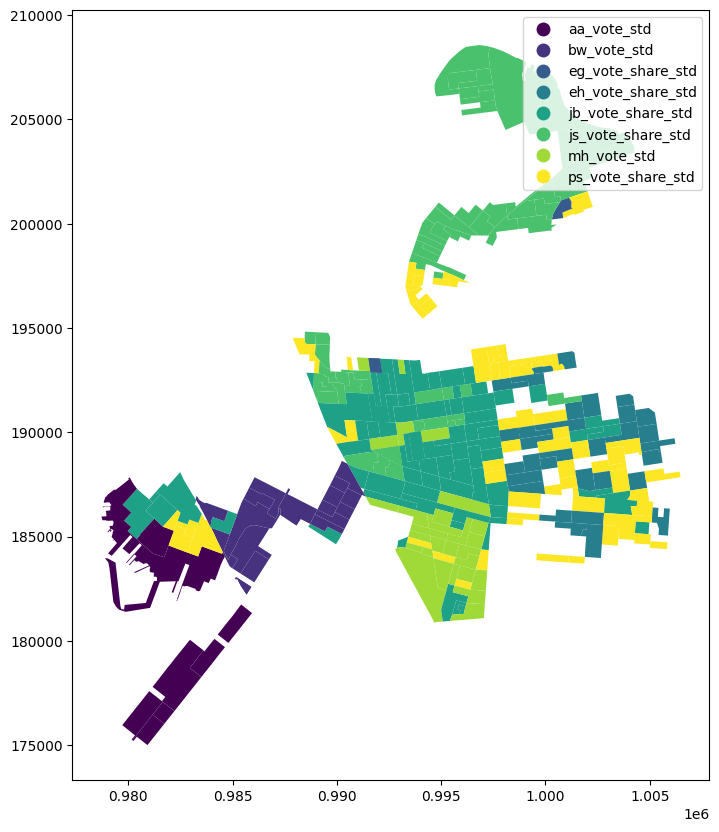

In [179]:
std_map.plot(column='highest_vote', cmap='viridis', legend=True, figsize=(10, 10))

In [182]:
vote_cols = ['ps_vote_share', 'jb_vote_share', 'js_vote_share', 'eh_vote_share','eg_vote_share',
             'mh_vote','bw_vote','jk_vote','tc_vote','aa_vote']

In [220]:
council_and_ass['dsa_vote'] = council_and_ass.apply(compute_dsa_vote, axis=1)

In [221]:
caa = council_and_ass[['ed_name','dsa_vote']]

In [222]:
caa = caa.merge(ed_gdf,left_on='ed_name',right_on='ElectDist',how='left')

In [223]:
caa_map = gpd.GeoDataFrame(caa,geometry=caa['geometry'])

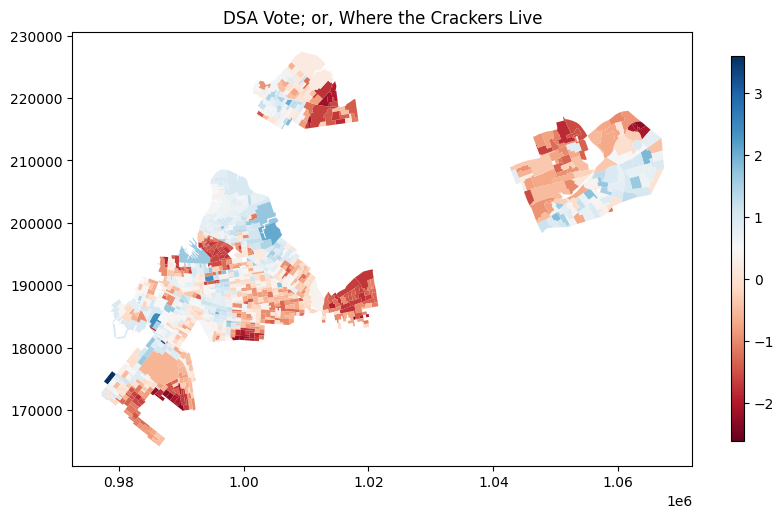

In [228]:
vmin, vmax = caa_map['dsa_vote'].min(), caa_map['dsa_vote'].max()
caa_map.plot(column='dsa_vote', cmap='RdBu', legend=True, figsize=(10, 10),
             vmin=vmin, vmax=vmax,
             legend_kwds={'shrink': 0.5, 'aspect': 30}) 
plt.title('DSA Vote; or, Where the Crackers Live')
plt.show()